<a href="https://colab.research.google.com/github/yasminsoltani/Sleep-Stage-Classifier/blob/main/Sleep_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Preprocessing

In [ ]:
!pip install pyedflib
!pip install mne
!pip install imblearn
!pip install xgboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2745155 sha256=35ee302de11de24f89fc33022d2f474c364378605e86fd6e76a4d37f4d397b9b
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyedflib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 90.4 MB/s eta 0:00:00


In [22]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
edf_folder = "/content/drive/MyDrive/EEGData/EDF data"
all_files = sorted(os.listdir(edf_folder))
psg_files = [f for f in all_files if 'PSG.edf' in f]
hypnogram_files = [f for f in all_files if 'Hypnogram.edf' in f]

print("PSG files:", psg_files)
print("Hypnogram files:", hypnogram_files)


PSG files: ['SC4001E0-PSG.edf', 'SC4002E0-PSG.edf', 'SC4011E0-PSG.edf', 'SC4012E0-PSG.edf', 'SC4021E0-PSG.edf', 'SC4022E0-PSG.edf', 'SC4031E0-PSG.edf', 'SC4032E0-PSG.edf', 'SC4041E0-PSG.edf', 'SC4042E0-PSG.edf', 'SC4051E0-PSG.edf', 'SC4052E0-PSG.edf', 'SC4061E0-PSG.edf', 'SC4062E0-PSG.edf', 'SC4071E0-PSG.edf', 'SC4072E0-PSG.edf', 'SC4081E0-PSG.edf', 'SC4082E0-PSG.edf', 'SC4091E0-PSG.edf', 'SC4092E0-PSG.edf', 'SC4101E0-PSG.edf', 'SC4102E0-PSG.edf', 'SC4111E0-PSG.edf', 'SC4112E0-PSG.edf', 'SC4121E0-PSG.edf', 'SC4122E0-PSG.edf', 'SC4131E0-PSG.edf', 'SC4141E0-PSG.edf', 'SC4142E0-PSG.edf', 'SC4151E0-PSG.edf', 'SC4152E0-PSG.edf', 'SC4161E0-PSG.edf', 'SC4162E0-PSG.edf', 'SC4171E0-PSG.edf', 'SC4172E0-PSG.edf', 'SC4181E0-PSG.edf', 'SC4182E0-PSG.edf', 'SC4191E0-PSG.edf', 'SC4201E0-PSG.edf', 'SC4202E0-PSG.edf', 'SC4211E0-PSG.edf', 'SC4212E0-PSG.edf', 'SC4221E0-PSG.edf']
Hypnogram files: ['SC4001EC-Hypnogram.edf', 'SC4002EC-Hypnogram.edf', 'SC4011EH-Hypnogram.edf', 'SC4012EC-Hypnogram.edf', 'SC402

In [25]:
for psg_file, hyp_file in zip(psg_files, hypnogram_files):
    psg_path = os.path.join(edf_folder, psg_file)
    hyp_path = os.path.join(edf_folder, hyp_file)
    print(f"PSG path: {psg_path}")
    print(f"Hypnogram path: {hyp_path}")


PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4001E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/SC4001EC-Hypnogram.edf
PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4002E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/SC4002EC-Hypnogram.edf
PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4011E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/SC4011EH-Hypnogram.edf
PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4012E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/SC4012EC-Hypnogram.edf
PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4021E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/SC4021EH-Hypnogram.edf
PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4022E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/SC4022EJ-Hypnogram.edf
PSG path: /content/drive/MyDrive/EEGData/EDF data/SC4031E0-PSG.edf
Hypnogram path: /content/drive/MyDrive/EEGData/EDF data/S

In [26]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True,
                             crop_wake_mins=30):

    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()

    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, preload=True)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)

    if not load_eeg_only:
        raw.set_channel_types(mapping)

    # cropping block
    if crop_wake_mins > 0:
        mask = [desc[-1] in ['1', '2', '3', '4', 'R'] for desc in annots.description]
        sleep_event_inds = np.where(mask)[0]
        if len(sleep_event_inds) > 0:
            tmin = annots[sleep_event_inds[0]]['onset'] - crop_wake_mins * 60
            tmax = annots[sleep_event_inds[-1]]['onset'] + crop_wake_mins * 60
            raw.crop(tmin=tmin, tmax=tmax)
        else:
            print(f"No sleep stages found in annotations for {os.path.basename(raw_fname)} — skipping crop.")

    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)

    # Only set valid subject info keys
    basename = os.path.basename(raw_fname)
    subj_nb = int(basename[3:5])
    raw.info['subject_info'] = {'id': subj_nb}

    return raw


In [27]:
subjects_raw = {}
for psg_file, hyp_file in zip(psg_files, hypnogram_files):
    subject_id = psg_file.split('-')[0]
    psg_path = os.path.join(edf_folder, psg_file)
    hyp_path = os.path.join(edf_folder, hyp_file)

    try:
        raw = load_sleep_physionet_raw(psg_path, hyp_path, load_eeg_only=True)
        subjects_raw[subject_id] = raw
        print(f"Loaded {subject_id}: shape = {raw.get_data().shape}")
    except Exception as e:
        print(f"Failed to load {subject_id}: {e}")


Extracting EDF parameters from /content/drive/MyDrive/EEGData/EDF data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Loaded SC4001E0: shape = (2, 2508001)
Extracting EDF parameters from /content/drive/MyDrive/EEGData/EDF data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Loaded SC4002E0: shape = (2, 3348001)
Extracting EDF parameters from /content/drive/MyDrive/EEGData/EDF data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Loaded SC4011E0: shape = (2, 3261001)
Extracting EDF parameters from /content/drive/MyDrive/EEGData/EDF data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 85

In [28]:
raw = subjects_raw["SC4001E0"]
print("Start time (sec):", raw.times[0])
print("End time (sec):", raw.times[-1])
print("Duration (min):", raw.times[-1] / 60)

Start time (sec): 0.0
End time (sec): 25080.0
Duration (min): 418.0


### Data Preprocessing

Stage mapping

In [29]:
stage_map = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4,  # Combine with stage 3
    'Sleep stage R': 5
}

def process_subject(subject_id, raw, stage_map):
    # Convert annotations to events (30s window)
    events, _ = mne.events_from_annotations(
        raw, event_id=stage_map, chunk_duration=30.0
    )

    sfreq = raw.info["sfreq"]
    tmax = 30.0 - 1.0 / sfreq

    epochs = mne.Epochs(
        raw=raw,
        events=events,
        event_id=stage_map,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
        preload=True
    )

    return epochs

# Process all subjects
all_epochs = {}
for subject_id, raw in subjects_raw.items():
    try:
        epochs = process_subject(subject_id, raw, stage_map)
        all_epochs[subject_id] = epochs
        print(f"Processed {subject_id}: {len(epochs)} epochs")
    except Exception as e:
        print(f"Failed for {subject_id}: {e}")


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
836 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 836 events and 3000 original time points ...
0 bad epochs dropped
Processed SC4001E0: 836 epochs
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1115 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1115 events and 3000 original time points ...
0 bad epochs dropped
Processed SC4002E0: 1115 epochs
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('

In [30]:
all_epochs

{'SC4001E0': <Epochs | 836 events (all good), 0 – 29.99 s (baseline off), ~38.3 MiB, data loaded,
  'Sleep stage W': 183
  'Sleep stage 1': 58
  'Sleep stage 2': 250
  'Sleep stage 3': 220
  'Sleep stage 4': 220
  'Sleep stage R': 125>,
 'SC4002E0': <Epochs | 1115 events (all good), 0 – 29.99 s (baseline off), ~51.0 MiB, data loaded,
  'Sleep stage W': 171
  'Sleep stage 1': 59
  'Sleep stage 2': 373
  'Sleep stage 3': 297
  'Sleep stage 4': 297
  'Sleep stage R': 215>,
 'SC4011E0': <Epochs | 1087 events (all good), 0 – 29.99 s (baseline off), ~49.8 MiB, data loaded,
  'Sleep stage W': 141
  'Sleep stage 1': 109
  'Sleep stage 2': 562
  'Sleep stage 3': 105
  'Sleep stage 4': 105
  'Sleep stage R': 170>,
 'SC4012E0': <Epochs | 1149 events (all good), 0 – 29.99 s (baseline off), ~52.6 MiB, data loaded,
  'Sleep stage W': 125
  'Sleep stage 1': 92
  'Sleep stage 2': 660
  'Sleep stage 3': 96
  'Sleep stage 4': 96
  'Sleep stage R': 176>,
 'SC4021E0': <Epochs | 1020 events (all good), 0 –

In [31]:
print(epochs.info["ch_names"])

['Fpz-Cz', 'Pz-Oz']


### Features Extraction

In [32]:
freq_bands = {
    "Delta": (0.5, 4.0),
    "Theta": (3.0, 8.0), #3-8
    "Alpha": (6.0, 14.0), #6-14
    "Beta": (12.0, 30.0) #12-30
}

In [33]:
def extract_normalized_band_features(epochs, bands):
    """
    Extracts 5 features per epoch from the Pz-Oz channel:
    - Total power (absolute)
    - Relative power in Delta, Theta, Alpha, Beta bands

    Returns:
    --------
    features : np.ndarray of shape (n_epochs, 5)
    """
    picks = ["Pz-Oz"]

    # Compute multitaper PSD
    psd_obj = epochs.compute_psd(method="multitaper", picks=picks, fmin=0.5, fmax=30)
    psd, freqs = psd_obj.get_data(return_freqs=True)  # shape: (n_epochs, 1, n_freqs)

    psd = psd[:, 0, :]  # remove channel axis → shape: (n_epochs, n_freqs)

    total_power = np.sum(psd, axis=1, keepdims=True)  # (n_epochs, 1)
    psd_norm = psd / total_power  # normalized PSD

    band_features = []
    for _, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs < high)
        band_power = np.sum(psd_norm[:, band_mask], axis=1, keepdims=True)
        band_features.append(band_power)

    features = np.concatenate([total_power] + band_features, axis=1)  # shape: (n_epochs, 5)
    return features


In [34]:
# Initialize lists BEFORE the loop
X_all, y_all, group_all = [], [], []

for subj_id, epochs in all_epochs.items():
    try:
        # Extract features using only Fpz-Cz
        X_band = extract_normalized_band_features(epochs, freq_bands)
        y = epochs.events[:, -1]  # Sleep stage labels

        groups = np.full(X_band.shape[0], subj_id)

        X_all.append(X_band)
        y_all.append(y)
        group_all.append(groups)

        print(f"Extracted features for {subj_id}: {len(y)} samples")

    except Exception as e:
        print(f"Failed for {subj_id}: {e}")


    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4001E0: 836 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4002E0: 1115 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4011E0: 1087 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4012E0: 1149 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4021E0: 1020 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4022E0: 1008 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4031E0: 950 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4032E0: 902 samples
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted features for SC4041E0: 1234 samples
    Using multitaper spectrum estimation

In [35]:
X = np.vstack(X_all)          # Feature matrix
y = np.concatenate(y_all)     # Labels
groups = np.concatenate(group_all)  # Group IDs (subject IDs)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("groups shape:", groups.shape)


X shape: (45209, 5)
y shape: (45209,)
groups shape: (45209,)


Number of epochs per participant: Counter({np.str_('SC4172E0'): 1770, np.str_('SC4152E0'): 1752, np.str_('SC4211E0'): 1577, np.str_('SC4191E0'): 1523, np.str_('SC4072E0'): 1271, np.str_('SC4052E0'): 1245, np.str_('SC4041E0'): 1234, np.str_('SC4042E0'): 1198, np.str_('SC4012E0'): 1149, np.str_('SC4161E0'): 1139, np.str_('SC4091E0'): 1130, np.str_('SC4081E0'): 1127, np.str_('SC4002E0'): 1115, np.str_('SC4092E0'): 1103, np.str_('SC4101E0'): 1097, np.str_('SC4221E0'): 1097, np.str_('SC4011E0'): 1087, np.str_('SC4102E0'): 1087, np.str_('SC4082E0'): 1053, np.str_('SC4121E0'): 1049, np.str_('SC4131E0'): 1024, np.str_('SC4021E0'): 1020, np.str_('SC4062E0'): 1012, np.str_('SC4022E0'): 1008, np.str_('SC4201E0'): 1005, np.str_('SC4141E0'): 1003, np.str_('SC4162E0'): 1002, np.str_('SC4122E0'): 972, np.str_('SC4071E0'): 969, np.str_('SC4171E0'): 951, np.str_('SC4031E0'): 950, np.str_('SC4142E0'): 948, np.str_('SC4181E0'): 941, np.str_('SC4151E0'): 940, np.str_('SC4111E0'): 924, np.str_('SC4182E0'):

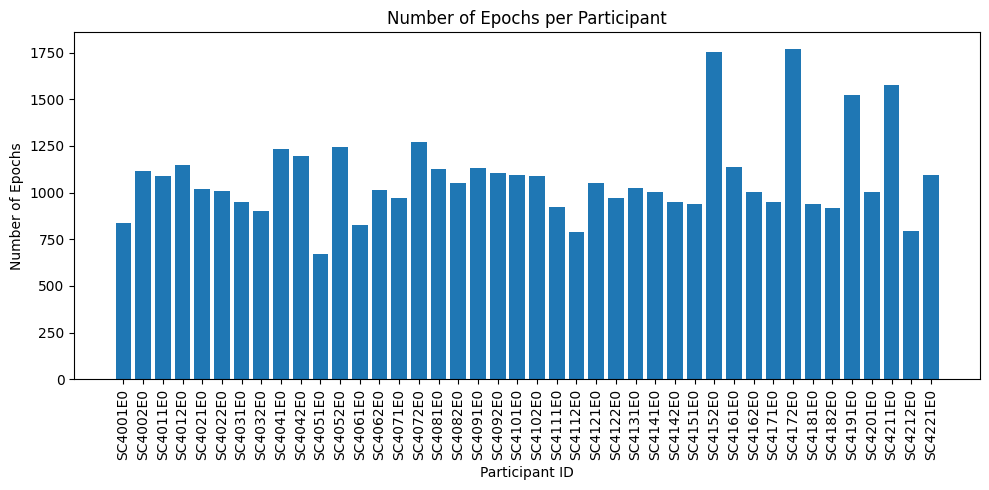

In [36]:
# Count number of epochs per participant
participant_counts = Counter(groups)
print("Number of epochs per participant:", participant_counts)

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar(participant_counts.keys(), participant_counts.values())
plt.xlabel("Participant ID")
plt.ylabel("Number of Epochs")
plt.title("Number of Epochs per Participant")
plt.xticks(rotation=90)  # in case IDs are long
plt.tight_layout()
plt.show()


### Visualization of features

### Scatter plot

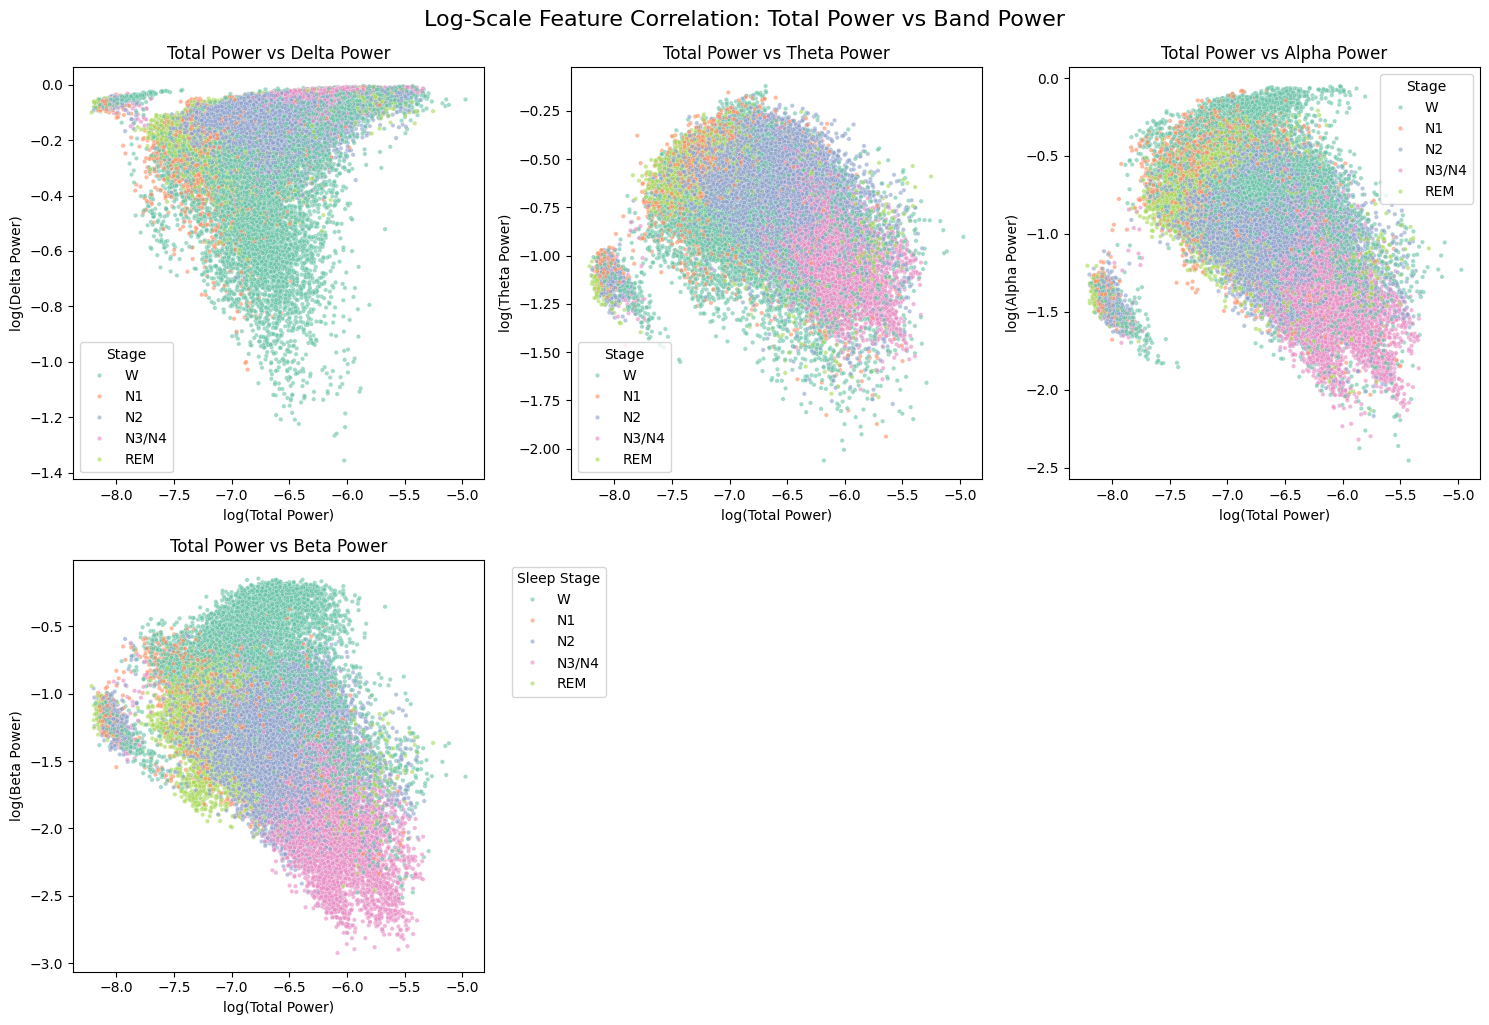

In [37]:
# Sleep stage mapping
stage_map = {1: 'W', 2: 'N1', 3: 'N2', 4: 'N3/N4', 5: 'REM'}
y_labels = pd.Series(y).map(stage_map)

# Create DataFrame with labeled columns
df_features = pd.DataFrame(X, columns=["Total", "Delta", "Theta", "Alpha", "Beta"])
df_features["Stage"] = y_labels

# Apply log10 transform (add small epsilon to avoid log(0))
epsilon = 1e-10
df_log = df_features.copy()
for col in ["Total", "Delta", "Theta", "Alpha", "Beta"]:
    df_log[col] = np.log10(df_log[col] + epsilon)

# Plot: log(Total Power) vs. log(Band Power)
bands = ["Delta", "Theta", "Alpha", "Beta"]

plt.figure(figsize=(15, 10))
for i, band in enumerate(bands, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_log, x="Total", y=band, hue="Stage", alpha=0.6, palette="Set2", s=10)
    plt.title(f"Total Power vs {band} Power")
    plt.xlabel("log(Total Power)")
    plt.ylabel(f"log({band} Power)")

plt.tight_layout()
plt.suptitle("Log-Scale Feature Correlation: Total Power vs Band Power", fontsize=16, y=1.02)
plt.legend(title="Sleep Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### PCA

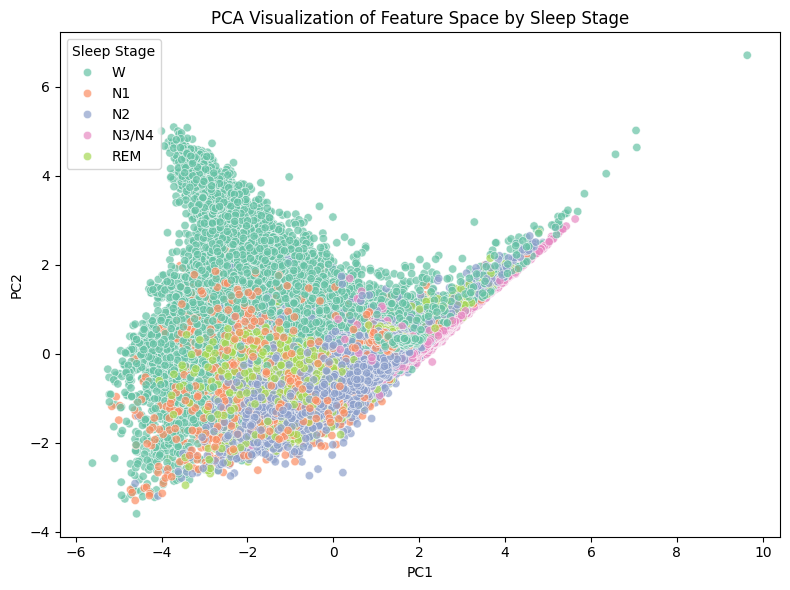

Explained variance by PC1: 52.86%
Explained variance by PC2: 23.32%


In [38]:
X = np.vstack(X_all)
y = np.concatenate(y_all)

# 1. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Map stage labels to readable names
stage_map = {1: 'W', 2: 'N1', 3: 'N2', 4: 'N3/N4', 5: 'REM'}
y_labels = pd.Series(y).map(stage_map)

# 4. Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Stage"] = y_labels

# 5. Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Stage", palette="Set2", alpha=0.7)
plt.title("PCA Visualization of Feature Space by Sleep Stage")
plt.legend(title="Sleep Stage")
plt.tight_layout()
plt.show()

# 6. Check how much variance is explained
explained = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained[0]:.2%}")
print(f"Explained variance by PC2: {explained[1]:.2%}")


### tSNE

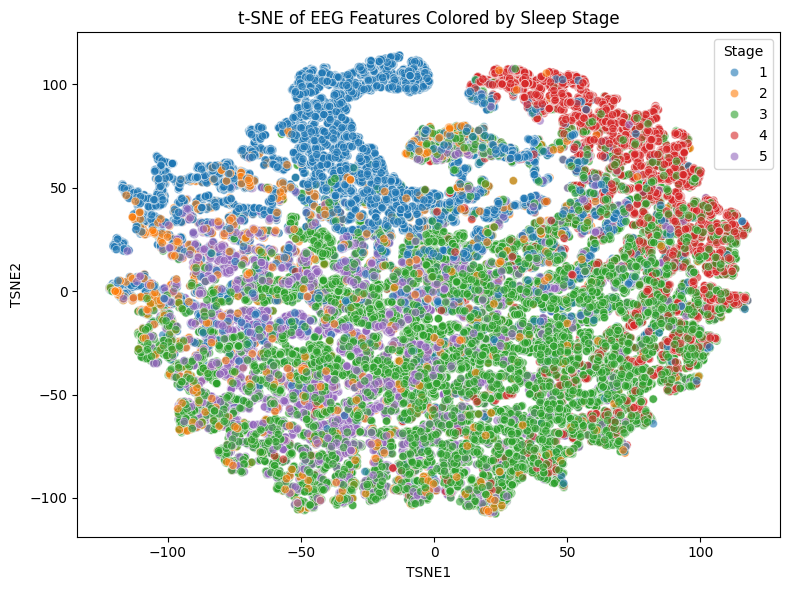

In [39]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X)

# Create DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Stage"] = y

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Stage", palette="tab10", alpha=0.6)
plt.title("t-SNE of EEG Features Colored by Sleep Stage")
plt.tight_layout()
plt.show()


### Cross-Validation

In [40]:
# Shuffle the dataset (X, y, groups are already created from earlier steps)
X, y, groups = shuffle(X, y, groups)  # No random_state → different shuffle every time

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Perform group-aware cross-validation
fold = 0
for train_idx, test_idx in gkf.split(X, y, groups=groups):
    print(f"\nFold #{fold + 1}")

    # Get train/test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Participant IDs for each set
    train_groups = np.unique(groups[train_idx])
    test_groups = np.unique(groups[test_idx])

    print(f"Train groups: {train_groups}")
    print(f"Test group: {test_groups}")
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    fold += 1

    # Optional: remove this to run full CV
    break



Fold #1
Train groups: ['SC4001E0' 'SC4002E0' 'SC4011E0' 'SC4012E0' 'SC4021E0' 'SC4031E0'
 'SC4032E0' 'SC4041E0' 'SC4042E0' 'SC4051E0' 'SC4052E0' 'SC4062E0'
 'SC4071E0' 'SC4072E0' 'SC4081E0' 'SC4082E0' 'SC4091E0' 'SC4092E0'
 'SC4101E0' 'SC4102E0' 'SC4111E0' 'SC4112E0' 'SC4122E0' 'SC4131E0'
 'SC4141E0' 'SC4142E0' 'SC4152E0' 'SC4162E0' 'SC4181E0' 'SC4182E0'
 'SC4191E0' 'SC4201E0' 'SC4211E0' 'SC4212E0']
Test group: ['SC4022E0' 'SC4061E0' 'SC4121E0' 'SC4151E0' 'SC4161E0' 'SC4171E0'
 'SC4172E0' 'SC4221E0']
Train shape: (36428, 5), Test shape: (8781, 5)


In [41]:
X_all_temporal, y_all, group_all = [], [], []
n_context = 1  # Number of neighbors on each side (e.g., 1 means t-1, t, t+1)

for subj_id, epochs in all_epochs.items():
    try:
        # --- Extract normalized features (6 per epoch) ---
        X_subj_base = extract_normalized_band_features(epochs, freq_bands)
        y_subj = epochs.events[:, -1]
        n_subj_epochs, n_base_features = X_subj_base.shape

        # --- Create temporal context features ---
        X_subj_temporal_list = [X_subj_base]  # Start with t (current)

        for i in range(1, n_context + 1):
            # t - i (previous context)
            X_prev = np.pad(X_subj_base[:-i], ((i, 0), (0, 0)), mode='edge')
            X_subj_temporal_list.insert(0, X_prev)  # prepend

            # t + i (future context)
            X_next = np.pad(X_subj_base[i:], ((0, i), (0, 0)), mode='edge')
            X_subj_temporal_list.append(X_next)  # append

        # --- Stack features: [t-1 | t | t+1] => shape: (n_epochs, 3 × 6 = 18)
        X_subj_temporal = np.concatenate(X_subj_temporal_list, axis=1)

        # --- Store results ---
        groups_subj = np.full(len(y_subj), subj_id)
        X_all_temporal.append(X_subj_temporal)
        y_all.append(y_subj)
        group_all.append(groups_subj)

        print(f"Extracted temporal features for {subj_id}: {len(y_subj)} samples, {X_subj_temporal.shape[1]} features")

    except Exception as e:
        print(f"Failed for {subj_id}: {e}")

# --- Final Aggregation ---
X = np.vstack(X_all_temporal)
y = np.concatenate(y_all)
groups = np.concatenate(group_all)

print("Temporal X shape:", X.shape)
print("y shape:", y.shape)
print("groups shape:", groups.shape)


    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4001E0: 836 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4002E0: 1115 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4011E0: 1087 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4012E0: 1149 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4021E0: 1020 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4022E0: 1008 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4031E0: 950 samples, 15 features
    Using multitaper spectrum estimation with 7 DPSS windows
Extracted temporal features for SC4032

In [42]:
# 1. Initialize GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Placeholder for results
fold_results = []
fold = 0

# 2. Cross-Validation Loop
for train_idx, test_idx in gkf.split(X, y, groups=groups):
    print(f"\n--- Fold #{fold + 1} ---")

    # 3. Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_groups = np.unique(groups[train_idx])
    test_groups = np.unique(groups[test_idx])

    print(f"Train groups: {train_groups}")
    print(f"Test group(s): {test_groups}")
    print(f"Original train shape: {X_train.shape}, Original test shape: {X_test.shape}")
    print(f"Original train class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")

    # 4. Scale Features (Fit ONLY on training data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # Use the same scaler fitted on train data

    # 5. Apply SMOTE (Fit ONLY on training data)
    # Note: SMOTE uses k-NN, so scaling beforehand is important.
    smote = SMOTE(random_state=42) # Use random_state for reproducibility
    print("Applying SMOTE to training data...")
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
    print(f"Train shape after SMOTE: {X_train_smote.shape}")
    print(f"Train class distribution after SMOTE:\n{pd.Series(y_train_smote).value_counts().sort_index()}")

    # 6. Train Classifier (using SMOTE-balanced data)
    print("Training classifier...")

    model = RandomForestClassifier (n_estimators=1000, random_state=42, n_jobs=-1)
    model.fit(X_train_smote, y_train_smote)

    # 7. Evaluate Classifier (using original, scaled test data)
    print("Evaluating classifier...")
    y_pred = model.predict(X_test_scaled)

    # Store or print results for this fold
    # report = classification_report(y_test, y_pred, output_dict=True)
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # **Crucially, ensure 'report_dict' is stored under the key 'report'**
    fold_results.append({
        'fold': fold,
        'accuracy': accuracy,
        'report': report_dict,  # Make sure this line exists and uses 'report' as the key
        'conf_matrix': conf_matrix
    })

    fold += 1
    # Remove break to run all folds
    # break



--- Fold #1 ---
Train groups: ['SC4001E0' 'SC4002E0' 'SC4011E0' 'SC4012E0' 'SC4021E0' 'SC4031E0'
 'SC4032E0' 'SC4041E0' 'SC4042E0' 'SC4051E0' 'SC4052E0' 'SC4062E0'
 'SC4071E0' 'SC4072E0' 'SC4081E0' 'SC4082E0' 'SC4091E0' 'SC4092E0'
 'SC4101E0' 'SC4102E0' 'SC4111E0' 'SC4112E0' 'SC4122E0' 'SC4131E0'
 'SC4141E0' 'SC4142E0' 'SC4152E0' 'SC4162E0' 'SC4181E0' 'SC4182E0'
 'SC4191E0' 'SC4201E0' 'SC4211E0' 'SC4212E0']
Test group(s): ['SC4022E0' 'SC4061E0' 'SC4121E0' 'SC4151E0' 'SC4161E0' 'SC4171E0'
 'SC4172E0' 'SC4221E0']
Original train shape: (36428, 15), Original test shape: (8781, 15)
Original train class distribution:
1     7171
2     2515
3    15744
4     4632
5     6366
Name: count, dtype: int64
Applying SMOTE to training data...
Train shape after SMOTE: (78720, 15)
Train class distribution after SMOTE:
1    15744
2    15744
3    15744
4    15744
5    15744
Name: count, dtype: int64
Training classifier...
Evaluating classifier...

--- Fold #2 ---
Train groups: ['SC4001E0' 'SC4002E0' 'SC401

In [43]:
# ================================================================
# AGGREGATE CROSS-VALIDATION RESULTS
# ================================================================

if not fold_results:
    print("The 'fold_results' list is empty. Did the cross-validation loop run correctly?")
else:
    print("\n===== Aggregating Cross-Validation Results =====")

    # 1. Calculate Mean and Standard Deviation of Overall Metrics
    accuracies = [res['accuracy'] for res in fold_results]
    # Ensure report structure exists before accessing nested keys
    macro_f1_scores = [res['report']['macro avg']['f1-score'] for res in fold_results if 'report' in res and 'macro avg' in res['report']]
    weighted_f1_scores = [res['report']['weighted avg']['f1-score'] for res in fold_results if 'report' in res and 'weighted avg' in res['report']]

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    mean_macro_f1 = np.mean(macro_f1_scores) if macro_f1_scores else float('nan')
    std_macro_f1 = np.std(macro_f1_scores) if macro_f1_scores else float('nan')

    mean_weighted_f1 = np.mean(weighted_f1_scores) if weighted_f1_scores else float('nan')
    std_weighted_f1 = np.std(weighted_f1_scores) if weighted_f1_scores else float('nan')

    print("\n--- Overall Performance (Mean +/- Std Dev across Folds) ---")
    print(f"Accuracy:              {mean_accuracy:.4f} +/- {std_accuracy:.4f}")
    print(f"Macro Avg F1-Score:    {mean_macro_f1:.4f} +/- {std_macro_f1:.4f}")
    print(f"Weighted Avg F1-Score: {mean_weighted_f1:.4f} +/- {std_weighted_f1:.4f}")

    # 2. Aggregate Confusion Matrix
    #    - Determine the number of classes. Assumes labels are consecutive integers starting from 1 or 0.
    #    - Uses the shape of the first stored matrix; requires consistent shapes.
    first_conf_matrix = fold_results[0].get('conf_matrix')
    if first_conf_matrix is not None:
        num_classes = first_conf_matrix.shape[0]
        total_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
        for res in fold_results:
            cm = res.get('conf_matrix')
            if cm is not None and cm.shape == (num_classes, num_classes):
                total_conf_matrix += cm
            else:
                print(f"Warning: Confusion matrix missing or shape mismatch in fold {res.get('fold', '?')}")

        print("\n--- Aggregate Confusion Matrix (Summed across all folds) ---")
        # Define labels based on your 'stage_map' (e.g., 1:W, 2:N1, 3:N2, 4:N3/4, 5:REM)
        # Ensure the order matches the confusion matrix rows/columns
        stage_labels = ['W', 'N1', 'N2', 'N3/N4', 'REM'] # MODIFY IF YOUR LABELS/ORDER ARE DIFFERENT
        if len(stage_labels) == num_classes:
             conf_matrix_df = pd.DataFrame(total_conf_matrix,
                                           index=[f' {l}' for l in stage_labels],
                                           columns=[f' {l}' for l in stage_labels])
             print(conf_matrix_df)
        else:
             print("(Label count mismatch, printing raw matrix)")
             print(total_conf_matrix) # Print raw matrix if labels don't match
    else:
        print("\nCould not aggregate confusion matrix (not found in first fold result).")


    # 3. Calculate Average Per-Class Metrics
    #    - Assumes class labels are strings '1', '2', '3', '4', '5' as keys in the report dict. Adjust if needed.
    class_labels = [label for label in fold_results[0]['report'].keys() if label.isdigit()]
    class_labels.sort() # Ensure consistent order

    if class_labels:
        print("\n--- Average Per-Class Metrics (Mean across Folds) ---")
        avg_metrics = {}
        for label in class_labels:
            precisions = [res['report'][label]['precision'] for res in fold_results if label in res.get('report', {})]
            recalls = [res['report'][label]['recall'] for res in fold_results if label in res.get('report', {})]
            f1s = [res['report'][label]['f1-score'] for res in fold_results if label in res.get('report', {})]

            if f1s: # Check if the class was present in the results
                avg_metrics[label] = {
                    'precision': np.mean(precisions),
                    'recall': np.mean(recalls),
                    'f1-score': np.mean(f1s)
                }
            else:
                 avg_metrics[label] = {'precision': float('nan'), 'recall': float('nan'), 'f1-score': float('nan')}


        # Display using Pandas DataFrame
        avg_metrics_df = pd.DataFrame(avg_metrics).T # Transpose to have labels as rows
        # Add stage names if available and labels match
        if len(stage_labels) == len(class_labels):
             avg_metrics_df.index = [f"Class {l} ({n})" for l, n in zip(class_labels, stage_labels)]
        else:
             avg_metrics_df.index = [f"Class {l}" for l in class_labels]

        print(avg_metrics_df[['precision', 'recall', 'f1-score']].round(4))
    else:
        print("\nCould not calculate average per-class metrics (class labels not found).")

print("\nAggregation finished.")


===== Aggregating Cross-Validation Results =====

--- Overall Performance (Mean +/- Std Dev across Folds) ---
Accuracy:              0.7256 +/- 0.0787
Macro Avg F1-Score:    0.6649 +/- 0.0785
Weighted Avg F1-Score: 0.7256 +/- 0.0793

--- Aggregate Confusion Matrix (Summed across all folds) ---
          W    N1     N2  N3/N4   REM
W      7210   864    531     83   259
N1      797  1062    689     27   610
N2      905   667  14672   1403  1647
N3/N4    86    13    849   4836    17
REM     373   751   1731     36  5091

--- Average Per-Class Metrics (Mean across Folds) ---
                 precision  recall  f1-score
Class 1 (W)         0.7706  0.8010    0.7848
Class 2 (N1)        0.3126  0.3362    0.3228
Class 3 (N2)        0.7920  0.7565    0.7736
Class 4 (N3/N4)     0.7565  0.8322    0.7918
Class 5 (REM)       0.6676  0.6390    0.6514

Aggregation finished.


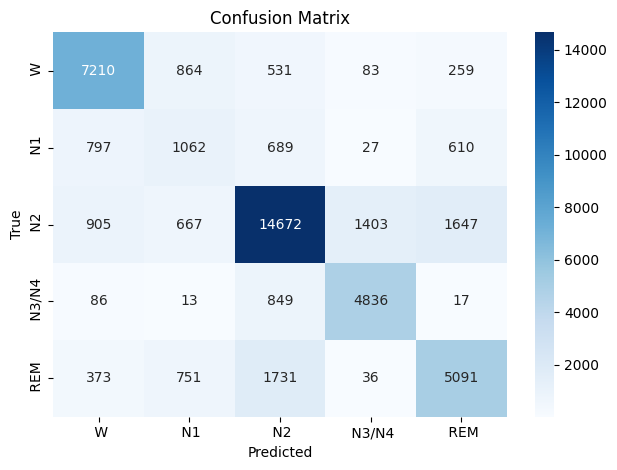

In [44]:
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()
